In [ ]:
!pip3 install nltk

In [23]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import seaborn as sbn
import torch
import joblib
import copy

from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from nltk.corpus import words
from dask import dataframe
from nltk.corpus import words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv")
test = pd.read_csv("/content/drive/MyDrive/challenge_log_data/test.csv")

In [ ]:
len(test)

1418916

In [20]:
train

,full_log,level,pre_log
0,localhost kibana typeerror timestamp tagswa...,0,localhost kibana typeerror timestamp tagswarn...
1,localhost logstash INFO logstash outputs el...,0,localhost logstash INFO logstash outputs elas...
2,typeSYSCALL gaudit archc e syscall successye...,1,typeSYSCALL gaudit archc syscall successyes ex...
3,typeSYSCALL gaudit archc e syscall successye...,1,typeSYSCALL gaudit archc syscall successyes ex...
4,localhost logstash WARN logstash outputs el...,0,localhost logstash WARN logstash outputs elas...
...,...,...,...
59786,localhost sshd ad protocol version identific...,6,localhost sshd ad protocol version identifica...
59787,localhost kernel device virbr nic entered pro...,6,localhost kernel device virbr nic entered pro...
59788,localhost kernel device enp s entered promisc...,6,localhost kernel device enp entered promiscuo...
59789,localhost useradd new group nametest GID,6,localhost useradd new group nametest GID


EDA
 1. 다양한 기호 및 숫자 제거 , 의미 없는 숫자와 기호들이 많아서 분류에 방해, NLTK 사전를 통해서 의미 없는 단어들을 처리

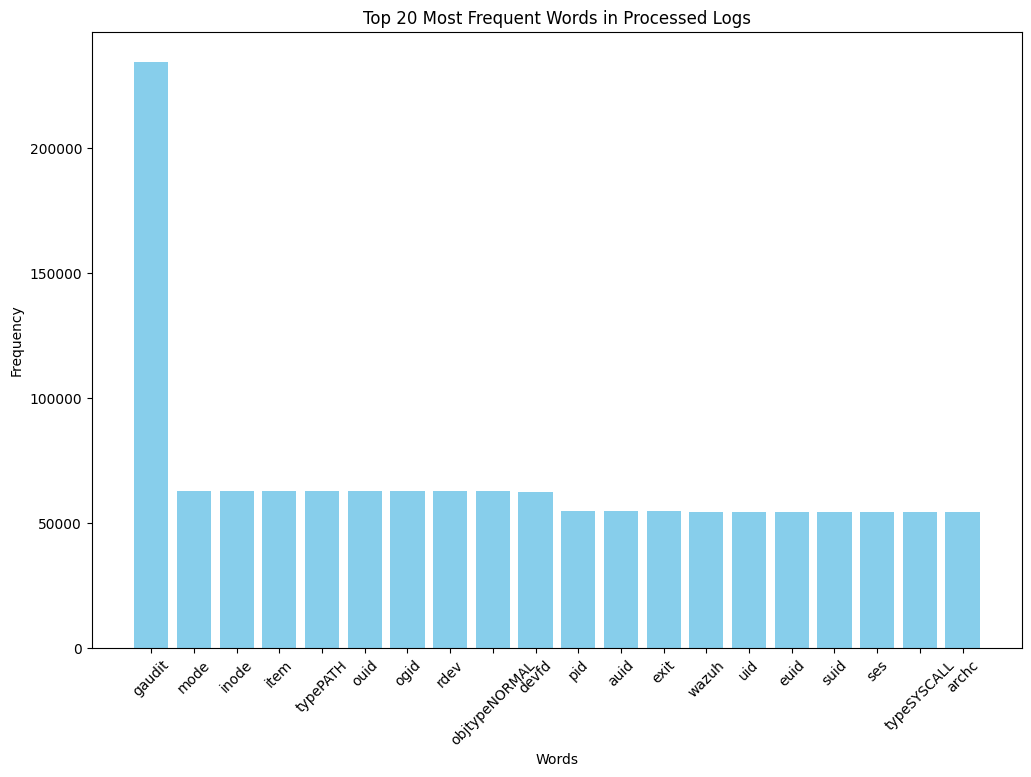

In [14]:
# 모든 전처리된 로그를 하나의 문자열로 결합
all_pre_logs = ' '.join(train['full_log'].astype(str).tolist())

# 단어 추출 및 필터링 (세 글자 이상인 단어만)
words = [word for word in re.findall(r'\b\w+\b', all_pre_logs) if len(word) >= 3]

# 빈도수 계산
word_counts = Counter(words)

# 가장 흔한 단어 추출 (상위 20개)
most_common_words = word_counts.most_common(20)

# 단어와 빈도수 분리
words, counts = zip(*most_common_words)

# 빈도수 시각화
plt.figure(figsize=(12, 8))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Processed Logs')
plt.xticks(rotation=45)
plt.show()

영어 단어가 아니거나 3글자 미만인 경우 삭제

In [15]:
# 포함되어 있는 단어 모음 생성
def count_word(data):
  tem = list(data['full_log'].str.split(" ")) ## prelog의 log 문자열을 ' ' 공백을 기준으로 나눔
  all_word = [] ##  빈 리스트 all_word를 초기화
  for word in tem: ## tem의 각 리스트(word)에 있는 단어들을 all_word 리스트에 추가
    all_word.extend(word)
  words = pd.Series(all_word) ## list를 pandas series 값으로 변환
  return words.value_counts() ## 단어의 빈도 계산 값 반환

In [16]:
train_count = count_word(train)
test_count = count_word(test)


In [17]:
train_words = list(set(train_count.index))
test_words = list(set(test_count.index))

In [38]:
# 단어가 NLTK 사전에 포함되어 있는지 확인하는 함수
def check_words(word_list: list, custom_words: list = None):
    if custom_words is None:
        custom_words = []
    special_words = ['os', 'localhost', 'kibana', 'exit', 'typeSYSCALL', 'typePATH', 'mode']
    results = {}
    for word in word_list:
        word_lower = word.lower()
        if word_lower in special_words:
            results[word_lower] = True
        elif len(word_lower) < 3:
            results[word_lower] = False
        elif word_lower in custom_words:
            results[word_lower] = True
        else:
            results[word_lower] = word_lower in english_words
    return results




In [20]:
## network log text중 가장 위험할 것 같은 text 선별
custom_word_list  = ['warning', 'ab', 'timeout', 'unauthorized', 'disconnect', 'connection', 'critical', 'alert', 'info', 'syscall', 'password', 'os']

In [21]:
# 상위 20개 단어와 병합
top_20_words = [word for word, count in most_common_words]
merged_word_list = list(set(custom_word_list + top_20_words))

In [24]:
# NLTK 사전 로드
nltk.download('words')
english_words = set(words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [25]:
# NLTK 라이브러리에 정의되어 있는지 확인, 있는 경우 True, NLTK 사전에 정의되어 있지 않은 경우 False 반환
nltk_check_result = check_words(merged_word_list, custom_word_list)

In [28]:
# 딕셔너리로 변환
nltk_check_dict = {word: valid for word, valid in nltk_check_result}

In [31]:
# train_words와 test_words에서 단어가 NLTK 사전에 없으면 제거하고, merged_word_list에서 False인 경우 유지
def filter_words(word_list, check_result, merged_words):
    filtered_words = []
    for word in word_list:
        word_lower = word.lower()
        if word_lower in merged_words and not check_result[word_lower]:
            filtered_words.append(word)
        elif check_result.get(word_lower, False):
            filtered_words.append(word)
    return filtered_words

In [41]:
# train_words와 test_words에 대해 필터링 수행
train_check_result = check_words(train_words, custom_word_list)
test_check_result = check_words(test_words, custom_word_list)


In [42]:
# 딕셔너리로 변환
train_check_dict = {word: valid for word, valid in train_check_result.items()}
test_check_dict = {word: valid for word, valid in test_check_result.items()}

filtered_train_words = filter_words(train_words, train_check_dict, nltk_check_dict)
filtered_test_words = filter_words(test_words, test_check_dict, nltk_check_dict)

# 단어인지 확인해주는 dictionary (train_isword, test_isword)
train_isword = {word.lower(): True for word in filtered_train_words}
test_isword = {word.lower(): True for word in filtered_test_words}



## 3. Train Test 에 각각 적용
nltk package를 사용해서 얻은 list 값으로 의미 없는 단어들을 제거


In [45]:
# 단어가 train_isword에 있는지 확인하는 함수
def checking_train(data):
    re = [False] * len(data)
    for i, word in enumerate(data):
        if word in train_isword:
            re[i] = True
    return re

def checking_test(data):
    re = [False] * len(data)
    for i, word in enumerate(data):
        if word in test_isword:
            re[i] = True
    return re

def cutt_train(data):
    data = data.lower()
    splited = data.split(" ")
    check = checking_train(splited)
    c = np.array(splited)
    real_words = list(c[check])
    tem = " ".join(real_words)
    return tem

def cutt_test(data):
    data = data.lower()
    splited = data.split(" ")
    check = checking_test(splited)
    c = np.array(splited)
    real_words = list(c[check])
    tem = " ".join(real_words)
    return tem

In [46]:
train['cut'] = train['full_log'].map(cutt_train)
test['cut'] = test['full_log'].map(cutt_test)

In [ ]:
del train['full_log']
del test['full_log']


del train['pre_log']
del test['pre_log']


In [ ]:
train['cut']

0         localhost kibana type error timestamp tags war...
1         feb localhost logstash info logstash outputs e...
2         localhost kibana type error timestamp tags war...
3         localhost kibana type error timestamp tags war...
4         type syscall msg audit arch syscall success ye...
                                ...                        
472967                        feb localhost logstash error 
472968    type syscall msg audit arch syscall success ye...
472969    localhost kibana type log timestamp tags error...
472970    localhost kibana type error timestamp tags war...
472971    localhost kibana type error timestamp tags war...
Name: cut, Length: 472972, dtype: object

In [ ]:
# 남은 단어가 없는  경우 공백으로 처리
train['cut'] = train['cut'].replace('',' ',regex=True)
test['cut'] = test['cut'].replace('',' ',regex=True)

In [ ]:
train.head()

,id,level,cut
0,0,0,localhost kibana type error timestamp tags war...
1,1,0,feb localhost logstash info logstash outputs e...
2,2,0,localhost kibana type error timestamp tags war...
3,3,0,localhost kibana type error timestamp tags war...
4,4,1,type syscall msg audit arch syscall success ye...


In [ ]:
train.to_csv('/content/drive/MyDrive/challenge_log_data/only_word_train', index = False)
test.to_csv('/content/drive/MyDrive/challenge_log_data/only_word_test', index = False)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_train')
test = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_test')

In [ ]:
# 남은 단어가 없는 경우에는 공백 으로 대체
train['cut'] = train['cut'].replace('',' ',regex = True)
test['cut'] = test['cut'].replace('',' ',regex = True)

train = train.fillna(" ")
test = test.fillna(" ")

train

,id,level,cut
0,0,0,type error warning collection level error erro...
1,1,0,action with response code type unavailable exc...
2,2,0,type error warning collection level error erro...
3,3,0,type error warning collection level error erro...
4,4,1,type audit arch success yes exit gid suid none...
...,...,...,...
472967,472967,0,error
472968,472968,1,type audit arch success yes exit gid suid none...
472969,472969,0,type log error task manager message poll for w...
472970,472970,0,type error warning collection level error erro...


In [ ]:
train_text = list(train['cut'])
train_level = np.array(train['level'])

test_text = list(test['cut'])

In [ ]:
vectorizer=CountVectorizer(analyzer="word", max_features=20000)
train_features=vectorizer.fit_transform(train_text)
test_features=vectorizer.transform(test_text)

In [ ]:
import torch
# 희소 행렬을 PyTorch 텐서로 변환하는 함수
def sparse_to_torch_tensor(sparse_matrix):
    sparse_coo = sparse_matrix.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_coo.row, sparse_coo.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_coo.data)
    shape = torch.Size(sparse_coo.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

# 변환
train_features_tensor = sparse_to_torch_tensor(train_features)
test_features_tensor = sparse_to_torch_tensor(test_features)

# 텐서를 파일로 저장하는 함수
def save_tensor_to_file(tensor, filename):
    torch.save(tensor, filename)

<ipython-input-11-254138b3cbae>:10: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [ ]:
# Save the data processing
save_tensor_to_file(train_features_tensor, '/content/drive/MyDrive/challenge_log_data/train_features_Counter.npz')
save_tensor_to_file(test_features_tensor, '/content/drive/MyDrive/challenge_log_data/test_features_Counter.npz')




In [ ]:

train_features_tensor = torch.load('/content/drive/MyDrive/challenge_log_data/train_features_Counter.npz')
test_features_tensor = torch.load('/content/drive/MyDrive/challenge_log_data/test_features_Counter.npz')

In [ ]:
def torch_tensor_to_sparse(tensor):
    indices = tensor._indices().numpy()
    values = tensor._values().numpy()
    shape = tensor.size()
    return scipy.sparse.coo_matrix((values, (indices[0], indices[1])), shape=shape)


In [ ]:
import scipy.sparse
train_features_tensor = torch_tensor_to_sparse(train_features_tensor)
test_features_tensor = torch_tensor_to_sparse(test_features_tensor)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_level, test_size=0.2, random_state=1, stratify=train_level)

In [ ]:
# Random Forest 모델 학습
forest = OneVsRestClassifier(RandomForestClassifier(random_state=1))
forest.fit(train_features, train_level)


OneVsRestClassifier(estimator=RandomForestClassifier(random_state=1))

In [ ]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}


In [ ]:
# GridSearchCV 정의
grid_search = GridSearchCV(forest, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# GridSearchCV 실행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f'Best hyperparameters: {grid_search.best_params_}')

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
# 최적의 모델로 검증 데이터 평가
best_model = grid_search.best_estimator_
validation_score = best_model.score(X_val, y_val)
print(f'Validation Score: {validation_score}')

In [ ]:
results = forest.predict(test_features)
results_proba = forest.predict_proba(test_features)

In [ ]:
def find_optimal_thresholds_and_plot_f1(model, X, y, classes):
    y_proba = model.predict_proba(X)
    y_bin = label_binarize(y, classes=classes)

    optimal_thresholds = {}
    plt.figure(figsize=(12, 8))

    for i, class_label in enumerate(classes):
        precision, recall, thresholds = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall)

        #  optimal threshold 값 찾기
        ix = np.argmax(f1_scores)
        optimal_threshold = thresholds[ix]

        optimal_thresholds[class_label] = optimal_threshold

        print(f'Class {class_label} - Optimal Threshold: {optimal_threshold}, F1 Score: {f1_scores[ix]}')

        # 시각화 F1-score vs. Threshold
        plt.plot(thresholds, f1_scores[:-1], label=f'Class {class_label} (Optimal threshold = {optimal_threshold:.2f})')
        plt.axvline(x=optimal_threshold, linestyle='--', label=f'Class {class_label} optimal threshold', color=plt.gca().lines[-1].get_color())

    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold for Each Class')
    plt.legend(loc='best')
    plt.show()

    return optimal_thresholds




Class 0 - Optimal Threshold: 0.4788778877887789, F1 Score: 0.999347680375353
Class 1 - Optimal Threshold: 0.4685878719768913, F1 Score: 0.998475126443723
Class 2 - Optimal Threshold: 1.0, F1 Score: 0.9565217391304348
Class 3 - Optimal Threshold: 0.45149223236240865, F1 Score: 0.999517024873219
Class 4 - Optimal Threshold: 1.0, F1 Score: 1.0
Class 5 - Optimal Threshold: 0.4089141004862237, F1 Score: 0.9884327511907463
Class 6 - Optimal Threshold: 0.5960524207996238, F1 Score: 1.0


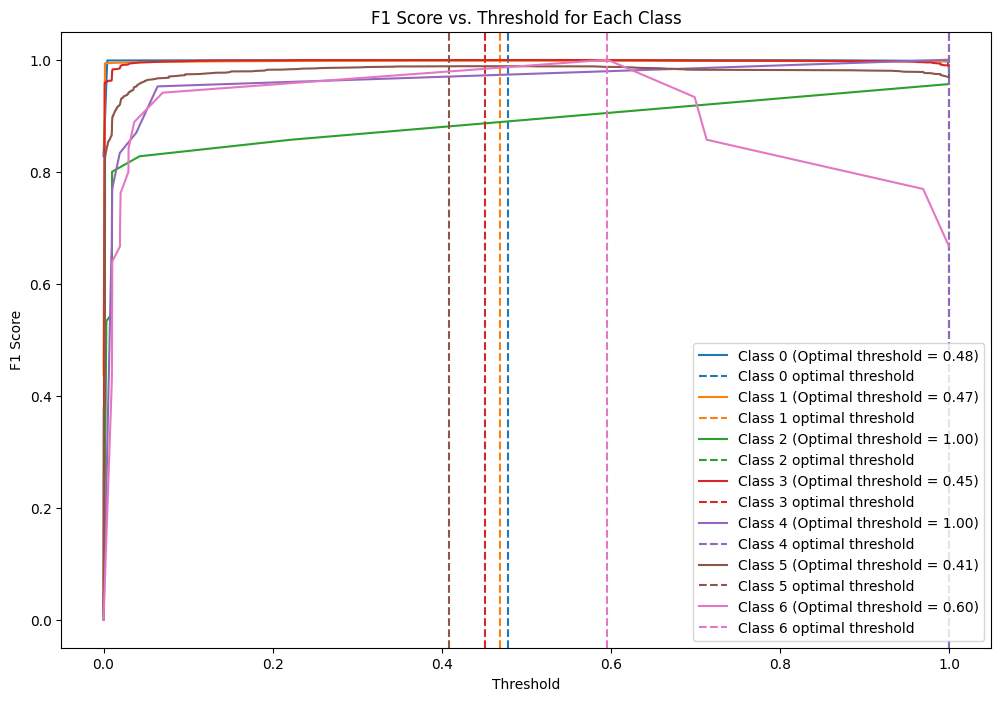

{0: 0.4788778877887789, 1: 0.4685878719768913, 2: 1.0, 3: 0.45149223236240865, 4: 1.0, 5: 0.4089141004862237, 6: 0.5960524207996238}


In [ ]:
# 클래스 라벨 얻기
classes = np.unique(train_level)

# 학습 데이터로 최적 임계값 찾기 및 F1-score vs. Threshold 플롯
optimal_thresholds = find_optimal_thresholds_and_plot_f1(forest, train_features, train_level, classes)
print(optimal_thresholds)


In [ ]:
# 최적 임계값을 적용하여 테스트 데이터에 대한 예측값 계산
results = forest.predict(test_features)
results_prob = forest.predict_proba(test_features)

In [ ]:
results[np.where((np.max(results_prob, axis=1)<0.48) & (results == 0))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.47) & (results == 1))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.5) & (results == 2))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.45) & (results == 3))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.5) & (results == 4))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.41) & (results == 5))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.6) & (results == 6))[0]]=7

In [ ]:
joblib.dump(forest,'/content/drive/MyDrive/challenge_log_data/rf')

['/content/drive/MyDrive/challenge_log_data/rf']

In [ ]:
loaded_rf = joblib.load('/content/drive/MyDrive/challenge_log_data/rf')

In [ ]:
results = loaded_rf.predict(test_features)
results_proba = loaded_rf.predict_proba(test_features)

In [ ]:
# 결과 저장
submission = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')
submission['level'] = results

submission['level'].value_counts()

level
0    1002589
1     396504
3      12976
5       6508
7        246
2         34
4         34
6         25
Name: count, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/challenge_log_data/submission_level_7.csv',index = False)